In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Read the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Feature Engineering
def feature_engineering(data):
    # Create new features
    data['trans_hour'] = pd.to_datetime(data['trans_time']).dt.hour
    data['age'] = (pd.to_datetime('today') - pd.to_datetime(data['dob'])).dt.days // 365
    data['distance'] = np.sqrt((data['lat'] - data['merch_lat'])**2 + (data['long'] - data['merch_long'])**2)
    data['amt_per_pop'] = data['amt'] / (data['city_pop'] + 1e-5)
    
    # Drop unnecessary columns
    drop_cols = ['trans_num', 'trans_date', 'trans_time', 'dob', 'first', 'last', 
                 'street', 'city', 'state', 'zip', 'cc_num']
    data.drop(columns=drop_cols, inplace=True, errors='ignore')
    
    return data

# Apply feature engineering
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

def preprocess_categorical(data):
    categorical_cols = data.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Use `sparse_output` for newer sklearn versions
    encoded_df = pd.DataFrame(
        encoder.fit_transform(data[categorical_cols]),
        columns=encoder.get_feature_names_out(categorical_cols)
    )
    # Drop original categorical columns and concatenate encoded features
    data = data.drop(columns=categorical_cols).reset_index(drop=True)
    return pd.concat([data, encoded_df], axis=1)

# Preprocess categorical features for train, validation, and test data
train_data = preprocess_categorical(train_data)
test_data = preprocess_categorical(test_data)


# Separate features and target for training
X = train_data.drop(columns=['is_fraud'])
y = train_data['is_fraud']

# Split train_data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle missing values and standardization
numeric_cols = X_train.select_dtypes(include=np.number).columns



/var/folders/93/cw2gyhy94hl1k1_tpyrbcrtw0000gn/T/ipykernel_27887/2258639490.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['trans_hour'] = pd.to_datetime(data['trans_time']).dt.hour
/var/folders/93/cw2gyhy94hl1k1_tpyrbcrtw0000gn/T/ipykernel_27887/2258639490.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['trans_hour'] = pd.to_datetime(data['trans_time']).dt.hour


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:30:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Soft Voting Classifier F1 Score: 0.9717


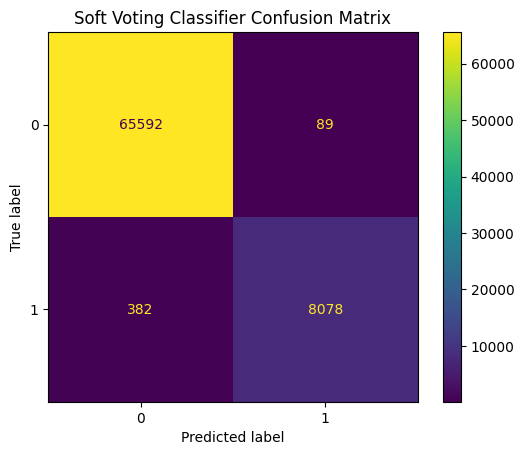

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predictions saved to 'submission.csv'.


In [8]:
# First Try submission.csv on Kaggle
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train[numeric_cols] = pipeline.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = pipeline.transform(X_val[numeric_cols])
X_test = pipeline.transform(test_data[numeric_cols])

# Define individual models
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define a soft voting classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Validate the model on validation data
val_predictions = voting_clf.predict(X_val)

# Evaluate on validation data
def evaluate_model(predictions, y_true, model_name):
    f1 = f1_score(y_true, predictions)
    print(f"{model_name} F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_true, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Evaluate the soft voting classifier
evaluate_model(val_predictions, y_val, "Soft Voting Classifier")

# Generate predictions for the test dataset
test_predictions = voting_clf.predict(X_test)

# Save predictions to submission.csv
submission = pd.DataFrame({
    'id': test_data['id'],
    'is_fraud': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Predictions saved to 'submission.csv'.")